# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP (he will teach the Geopanda lecture).
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass�) as follows:


In [1]:
# from IPython.display import Image
# Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(�MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)

## note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the no.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```


as opposed to just 

use the no.nansum etc
```
np.mean(mtarides)
np.sum(mtarides)
```

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.


## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

#i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

#removing empty light curves
```
tots = tots[tots.std(1)>0]
```

#with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

#and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

#then you can run:

```
km.fit(vals)
```

# HINTS: 


## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, dependingon the question) the appropriate dimension in different parts of the homework: when you need to work on the station level, collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average). The sum and average functions take an "axis" argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the dight axis.


# Possibly useful functions

I  used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
```
np.fft.rfft(mydata) 
```  

    will return the *real* part of the fourier transform (which is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math. All you need to know is that you need the real part). But what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the 
```
np.array.flatten()
np.array.reshape()
```
    array methods allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
from matplotlib import gridspec
import math
import statsmodels.api as sm
%matplotlib inline

In [3]:
mtaRides = np.load("MTA_Fare.npy")

In [4]:
#after reading the datacube you should see:
mtaRides.shape

(600, 23, 194)

ride types list

In [5]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 
                     'ada', 'afas', 'exp','ez','ff','mc','mr',
                     'month','rfm','rr','sen','spec','tcmc',
                     't', 'umlim','xbus','stud'])

In [6]:
mtaRides = mtaRides.astype('float')
mtaRides[mtaRides == -1] = np.NaN

In [7]:
mta = pd.DataFrame(np.nansum(mtaRides, axis= 1, keepdims= False).transpose())

In [8]:
mta.index = pd.date_range('05/28/2010', '02/14/2014', freq= 'W')

# Aggregating no. of swipes per week at the 600 stations 

In [9]:
mta['swipes'] = mta.sum(axis=1)
mta.head(4)

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,swipes
2010-05-30,126878.0,37306.0,6606.0,16378.0,18564.0,19987.0,12449.0,11091.0,10482.0,147187.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26720267.0
2010-06-06,149477.0,46464.0,6881.0,17408.0,19903.0,20625.0,13644.0,11659.0,11030.0,154826.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29265971.0
2010-06-13,152383.0,49359.0,7229.0,17595.0,19948.0,21225.0,13719.0,12037.0,10881.0,155958.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29601189.0
2010-06-20,160175.0,44849.0,5731.0,14242.0,16076.0,17412.0,11460.0,9809.0,9123.0,154914.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29387592.0


# The mean and stardand deviation of the time series can be used to set a 3-sigma threshold
# Every value that is more then 3 sigma's away from the mean can be flagged as an event

In [10]:
print ("Mean swipes per week {:.2f}".format(mta['swipes'].mean()))
print ("Stdev swipes per week {:.2f}".format(mta['swipes'].std()))
thresholds = [mta['swipes'].mean() + 3 * mta['swipes'].std(), 
              mta['swipes'].mean() - 3 * mta['swipes'].std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

Mean swipes per week 29781349.87
Stdev swipes per week 2991680.90
3-sigma thresholds 38756392.58 20806307.17


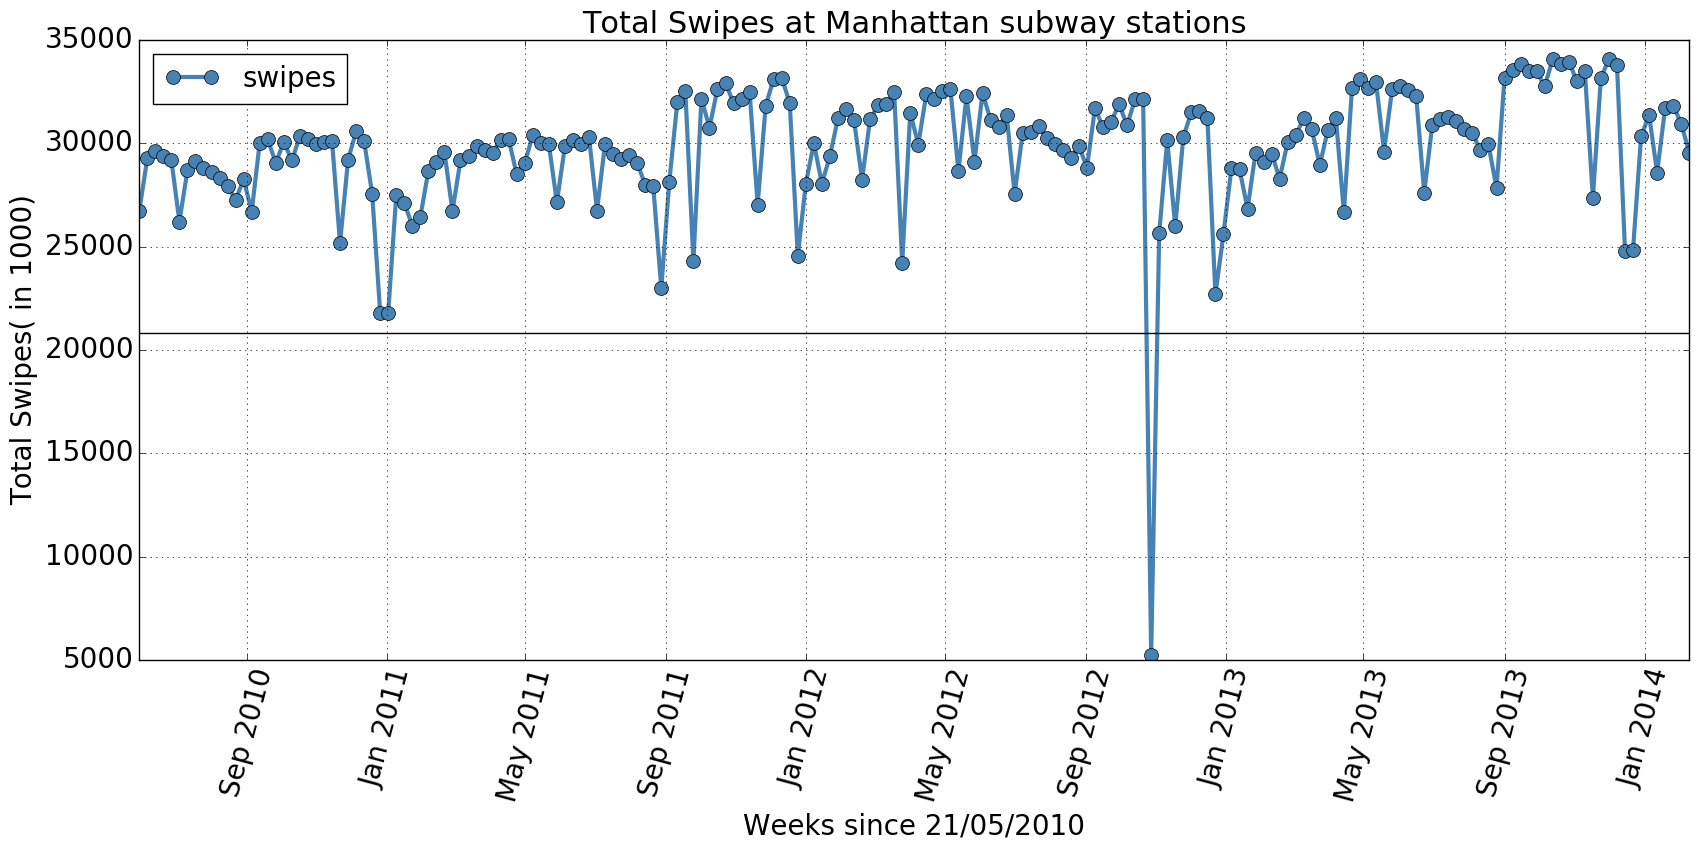

In [11]:
fig = pl.figure(figsize=(20,8))
ax = fig.gca()
ax.plot(mta.index, (mta.loc[:,'swipes'])/1000, 
        'o-',ms = 10, color="SteelBlue", lw = 3)
pl.xticks(rotation=75, fontsize=20)
pl.yticks(fontsize=20)
pl.grid()
pl.legend(loc = 'best', fontsize=20)
pl.xlabel("Weeks since 21/05/2010", fontsize=20)
pl.ylabel("Total Swipes( in 1000)", fontsize=20)
pl.title('Total Swipes at Manhattan subway stations', 
         fontsize=22)

pl.plot([ax.get_xlim()[0], ax.get_xlim()[1]], 
        [thresholds[1]/1000, thresholds[1]/1000], color='k')

## Figure 1: The figure shows the total swipes at the 600 Manhattan Subway Stations in the weeks from 28 May 2010 to 14 February 2014. A sudden drop of swipes is observed between October and November 2012 which denotes a event had occured. On checking the history, it shows that "Hurricane Sandy" had hit Manhattan at that time.  

In [12]:
print 'Lowest swipes observed on:'
print mta[mta.swipes < thresholds[1]]['swipes'].index

Lowest swipes observed on:
DatetimeIndex(['2012-10-28'], dtype='datetime64[ns]', freq='W-SUN')


In [13]:
mta2 = pd.DataFrame(np.nanmean(mtaRides, axis=0).T)
mta2.index = pd.date_range('05/28/2010', '02/14/2014', freq= 'W')
mta2.columns = ridetype
print mta2.shape
mta2.head()

(194, 23)


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-30,24880.119048,1148.320346,103.465368,403.790043,101.316017,8003.123377,18510.686147,21.781385,721.205628,1108.294372,...,266.523810,1710.194805,129.456710,61.084416,0.00000,269.898268,45.584416,13.264069,0.774892,NaN
2010-06-06,27173.229935,1265.798265,111.683297,432.167028,139.594360,8637.327549,20577.861171,25.698482,613.351410,1253.845987,...,329.605206,1969.778742,150.127983,70.136659,0.00000,264.019523,47.006508,13.275488,1.028200,NaN
2010-06-13,27573.708423,1266.077754,111.524838,431.248380,123.097192,8710.647948,20467.684665,26.516199,652.328294,1329.453564,...,327.295896,1974.349892,150.267819,70.449244,0.00000,263.889849,46.291577,14.017279,1.004320,NaN
2010-06-20,27329.751620,1215.123110,112.447084,424.166307,80.840173,8710.049676,20410.542117,24.235421,659.855292,1309.438445,...,317.697624,1949.349892,147.082073,69.987041,0.00000,263.609071,46.717063,14.233261,1.045356,NaN
2010-06-27,27607.099138,1182.883621,110.243534,420.006466,75.883621,8460.012931,20030.176724,22.661638,723.663793,1214.323276,...,297.172414,1843.907328,143.053879,68.821121,0.37931,258.137931,43.743534,13.605603,0.974138,NaN


In [14]:
y = mta2.iloc[:,0]
X = range(0,194)
X = sm.add_constant(X)
linmodel = sm.OLS(y, X).fit()

In [15]:
mta2.iloc[:,22] = pd.to_numeric( mta2.iloc[:,22] ,errors='coerce')

In [16]:
mta2.iloc[:,22] = np.nan_to_num(mta2.iloc[:,22])

10t cards flux ratio beginning to end:
0.977333883301
14d cards flux ratio beginning to end:
0.797624276433
1d cards flux ratio beginning to end:
0.898607285455
2t cards flux ratio beginning to end:
1.06947806198
30d cards flux ratio beginning to end:
0.966176473247
7d cards flux ratio beginning to end:
0.71859382072
ada cards flux ratio beginning to end:
1.10983615689
afas cards flux ratio beginning to end:
4768.55504872
exp cards flux ratio beginning to end:
93458.2159836
ez cards flux ratio beginning to end:
665116.356654
ff cards flux ratio beginning to end:
1.21961611899
mc cards flux ratio beginning to end:
0.822916862231
mr cards flux ratio beginning to end:
4.02698241547e-05
month cards flux ratio beginning to end:
1.72560081441
rfm cards flux ratio beginning to end:
1.53735901415
rr cards flux ratio beginning to end:
0.385131221691
sen cards flux ratio beginning to end:
0.343247655191
spec cards flux ratio beginning to end:
0.0142230182193
tcmc cards flux ratio beginning to en

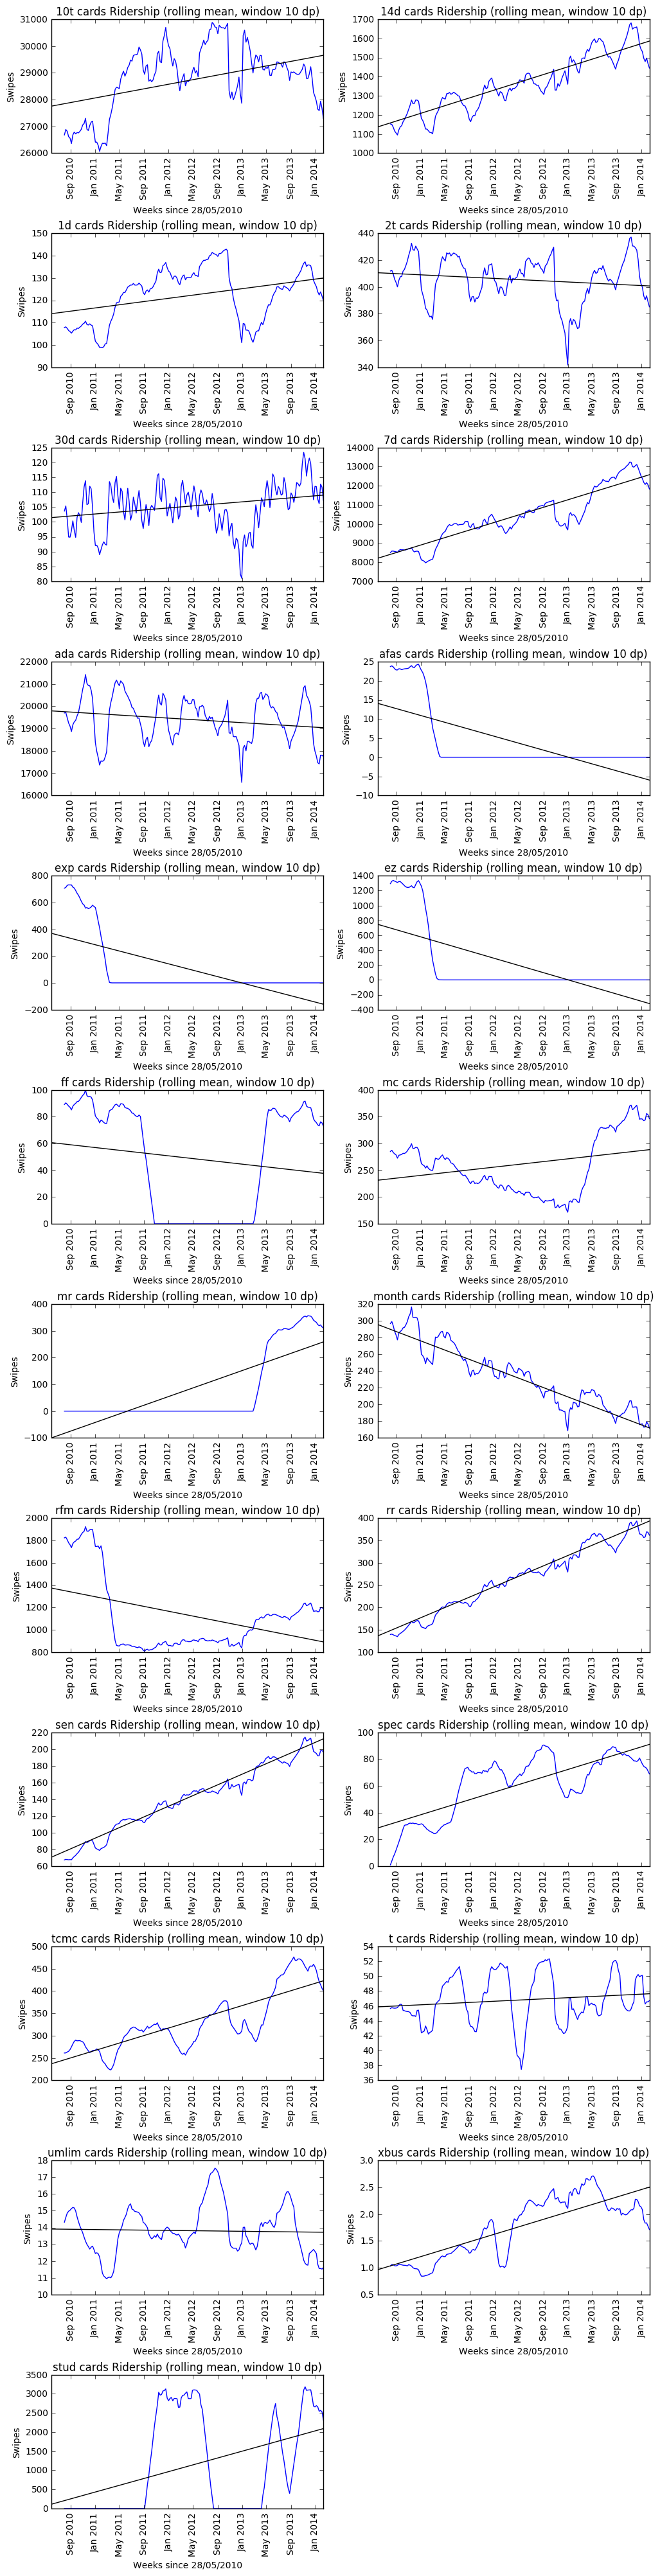

In [17]:
N = len(mta2.columns)
cols = 2
rows = 12

gs = gridspec.GridSpec(rows, cols)
fig = pl.figure(figsize=(12,50))

pl.subplots_adjust(hspace=0.6)
for i in range(len(mta2.columns)):
    print "{0} cards flux ratio beginning to end:\n{1}".\
    format(mta2.columns[i], mta2.iloc[0:10,i].sum() / mta2.iloc[184:194,i].sum())
    
    fig.add_subplot(gs[i])
#   mta2.iloc[:,i].rolling(window = 10).mean().plot(fontsize=10)
    pl.plot(mta2.index, mta2.iloc[:,i].rolling(window = 10).mean())
    pl.xticks(rotation = 'vertical')

    y = mta2.iloc[:,i]
#     y = mta2.iloc[:,i].rolling(window = 30).mean()
    X = range(len(mta2))
    X = sm.add_constant(X)
    linmodel = sm.OLS(y, X).fit()
    lin_pred = linmodel.predict(X)
    pl.plot(mta2.index, lin_pred, c = 'black', label='Predicted line')
    pl.title("{} cards Ridership (rolling mean, window 10 dp)".format(mta2.columns[i]), 
             fontsize=12)
    pl.xlabel("Weeks since 28/05/2010", fontsize=10)
    pl.ylabel("Swipes", fontsize=10)

## Figure 2: The above figures show trends in the number of swipes for 23 cards over the weeks from 28/05/2010 to 14/02/2014. 
### There are some time series who have more consistent trend than other series. Some series have structure with a trend. Some series have 0 values for most part of the time series so its diificult to find the trends in them.
### Some of the cards with steadily increasing and decreasing Time Series are: 14-Day, 7-Day, Transit Check Metrocard, Senior citizen/Disabled, Monthly, Rail Road. By how much the trend is increasing/decreasing is caluculated by the the ratio of usage in the first 10 and last 10 weeks, this is shown in above output
### Some cards like Reduced fair Media(RFM) have structure and a trend

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


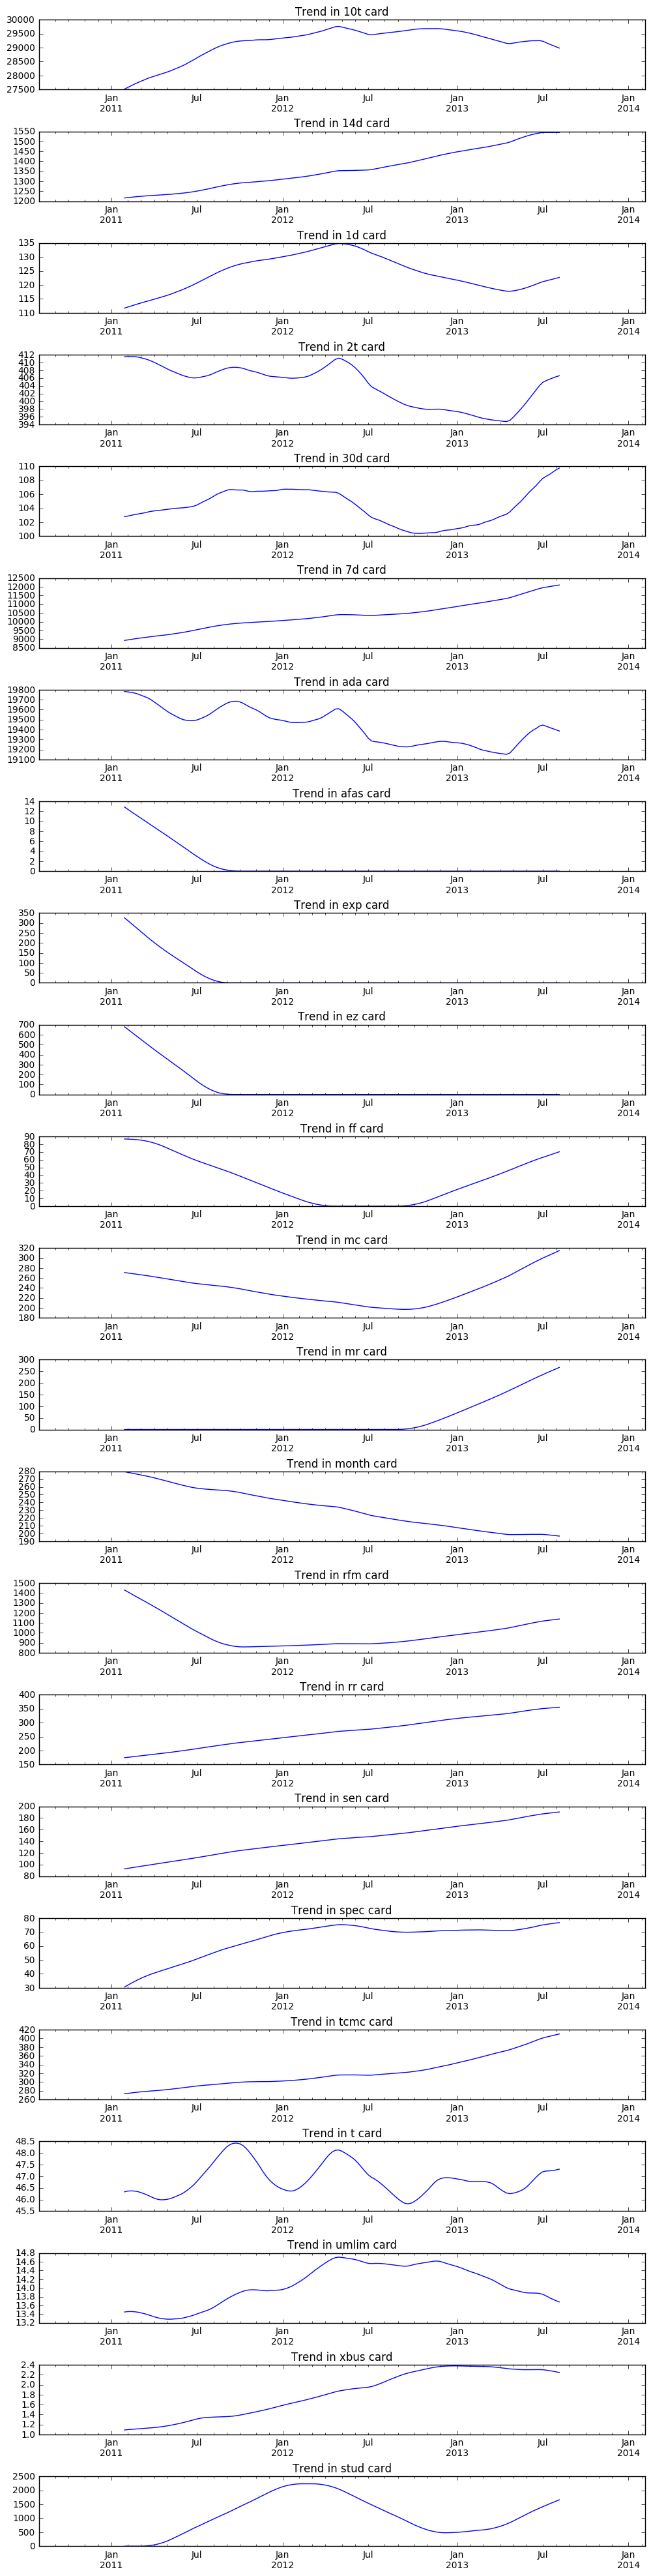

In [18]:
N = len(mta2.columns)
cols = 1
rows = 23

gs = gridspec.GridSpec(rows, cols)
fig = pl.figure(figsize=(12,50))

pl.subplots_adjust(hspace=0.6)

for i in range(len(mta2.columns)):
    fig.add_subplot(gs[i])
    res = sm.tsa.seasonal_decompose(mta2.iloc[:,i].rolling(window = 10).mean().dropna())
    pl.rcParams['figure.figsize']=(12,8)
    res.trend.plot()
    pl.title("Trend in {} card".format(mta2.columns[i]), 
             fontsize=12)

# Figure 3: The above figures show trends in the different card types. Though a trend seems to be appearing in each card type, the value range is quite low, eg. in case of 30 day cards the range is from 100 - 110, which is pretty low. 

In [19]:
sample_rate = 1
duration = 194

N = duration * sample_rate
freq = 1.0 / duration
period = 1.0 / freq

In [20]:
mta3 = pd.DataFrame(np.nansum(mtaRides, axis= 1, keepdims= False).transpose())

# The first two frequency caculated are infinity (1.0/0)  and the frequency corresponding to the entire duration of the series = N*d, and are removed because they are uninteresting

In [21]:
# Calculating the power spectrum of the ridership
f =pd.DataFrame(np.abs(np.fft.rfft(mta3.T)))
f = f.T
f = f.iloc[2:,:]

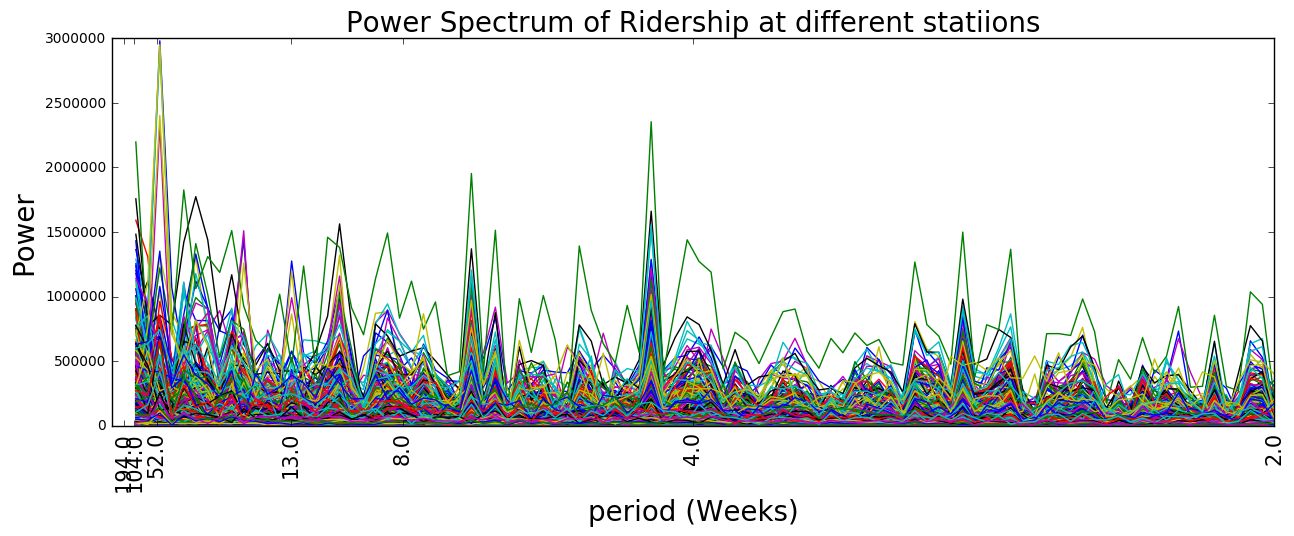

In [22]:

fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
ax.plot(np.fft.rfftfreq(N, 1.0)[2:], ((f)), '-')
ax.set_xticks([1./194,1./104,1./52,1./13,1./8,0.25,0.5])
ax.set_xticklabels([ "%s"%(1/m) for m in ax.get_xticks()], 
                   rotation=90, fontsize=15)
pl.xlabel("period (Weeks)", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Power Spectrum of Ridership at different statiions", fontsize=20)

## Figure 4: The above graph shows the power spectrum of the different riderships with respect to the weeks. We can observe the periodocity of the different time series, there is high periodocity at 52 weeks, i.e high annual periodocity. 

In [23]:
# Finding the maximum power spectrum values 
fmax = f.iloc[:,:].max()
print 'The top stations with highest periodicity and power spectrum values:\n',\
fmax.sort_values(ascending=False)[:4]

The top stations with highest periodicity and power spectrum values:
0      2.980161e+06
194    2.950389e+06
150    2.931896e+06
327    2.402219e+06
dtype: float64


In [24]:
mta3.index = pd.date_range('05/28/2010', '02/14/2014', freq= 'W')

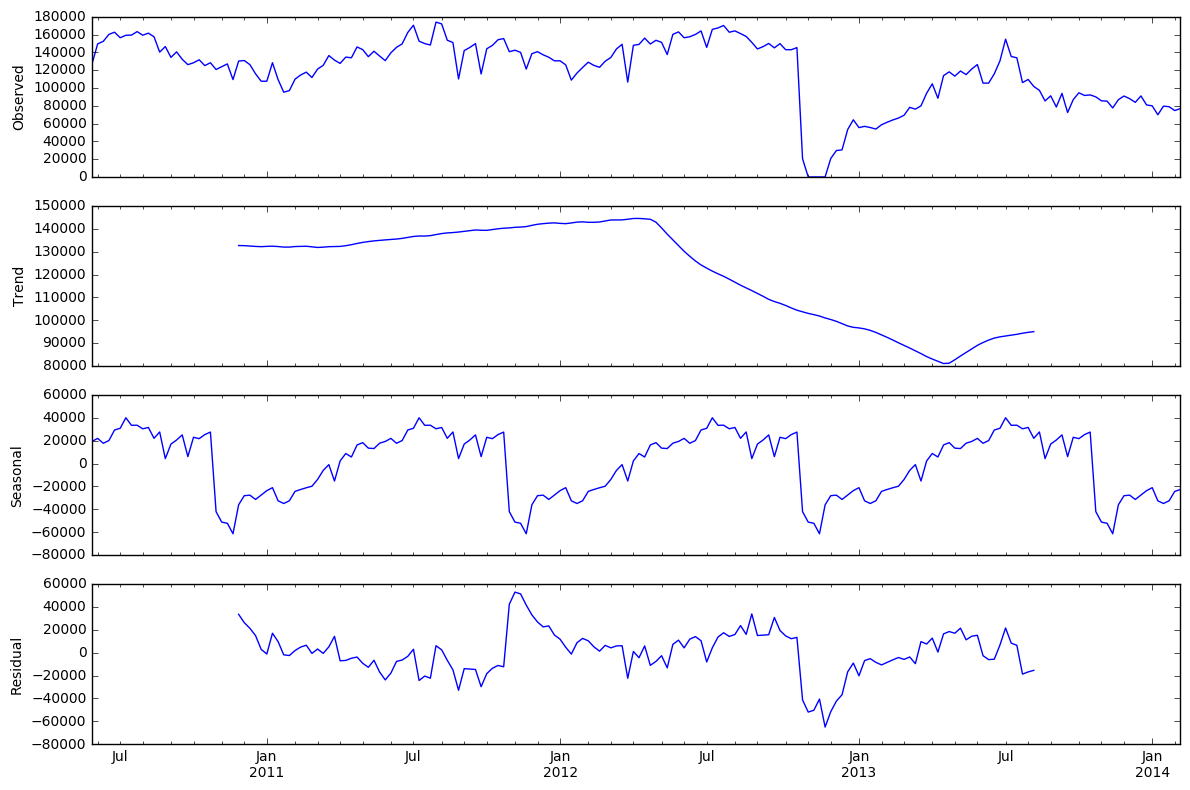

In [25]:
res = sm.tsa.seasonal_decompose(mta3.iloc[:,0].dropna())
resplot = res.plot()

# Figure 5 : The above plot shows the decomposed time series, we can see an annual high ridership periodicity around July and low around December. The high value may be because of Independence day and low maybe becasue of christmas 